# Tutorial: (Relaxed) Group Convolution


# [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iaifi/summer-school-2023/blob/main/Tutorial_Symmetry.ipynb)

This google colab tutorial is supporting material for the lectures by Robin Walters on *Incorporating Symmetry into Deep Dynamics Models* at [IAIFI Summer School](https://iaifi.org/phd-summer-school.html). We will 1) build regular group  convolution neural net layers; 2) define approximate equivariance and implement relaxed group convolution for translation group and C4 rotation group; 3) introduce basic ideas of steerable convolutions and [e2cnn](https://github.com/QUVA-Lab/e2cnn). 4) introduce several methods that can improve models' long-term dynmaics prediction accuracy.

This tutorial is based on the following materials:

* [Dr. Denis Boyda's tutorial](https://www.dropbox.com/sh/450ao3m5v4qt6o3/AABe1B2jEcyM5ZyoY_pmOStfa?dl=0) from IAIFI Summer School 2022.

* [UvA Deep Learning Tutorials](https://uvadlc-notebooks.readthedocs.io/en/latest/index.html).

* Prof. Erik Bekkers's course [Group Equivariant Deep Learning](https://www.youtube.com/@erikbekkers6398/videos).

* Cohen et al. [Group Equivariant Convolutional Networks](https://arxiv.org/pdf/1602.07576.pdf).

* Cohen et al. [Steerable CNNs](https://arxiv.org/abs/1612.08498).

* [E2CNN](https://github.com/QUVA-Lab/e2cnn) & [ESCNN](https://github.com/QUVA-Lab/escnn) & [E3NN](https://e3nn.org/)

* Wang et al. [Discovering Symmetry Breaking in Physical Systems with Relaxed Group Convolution](https://arxiv.org/abs/2310.02299).

* Wang and Walters et al. [Approximately Equivariant Networks for Imperfectly Symmetric Dynamics](https://proceedings.mlr.press/v162/wang22aa.html).


# 1. Group Equivariant Convolutional Networks

## 1.1 Group, Equivariance and Group Equivariant Convolutional Networks

### 1.1.1 Definition of group

A Group (or Abstract group) $G = (\Omega, \cdot)$ is a set with a binary operation, called group multiplication, that satisfies the following four axioms:

1.   <ins>Closure</ins>: For any $g_1, g_2 \in G$ the product $g_1 \cdot g_2 = g_3 \in G$.
2.   <ins>Associativity</ins>: For any $g_1, g_2, g_3 \in G$: ($g_1 \cdot g_2) \cdot g_3 = g_1 \cdot (g_2 \cdot g_3)$.
3.   <ins>Identity</ins>: There exists an identity element $e$ s.t. $e \cdot g = g \cdot e = g$ for each $g \in G$.
4.   <ins>Inverse</ins>: For any $g \in G$ there exists an inverse element $g^{-1} \in G$, s.t. $g \cdot g^{-1} = e$.

E.g. Translation Group $(R^2, +)$ consists of all possible translations in $R^2$ and is equipped with group product and group inverse,

$$g \cdot g' = (x + x') ; \;\;\ g^{-1} = -x $$

with $g = (x), g' = (x')$ and $x, x' \in \mathbb{R}^2$.

E.g. Roto-translation group $SE(2) = \mathbb{R}^2 \rtimes SO(2)$ consists of the coupled space of translation vectors and rotations and is equipped with group product and group inverse,
$$g \cdot g' = (x, R_{\theta}) \cdot (x', R_{\theta'}) = (R_{\theta}x' + x, R_{\theta+\theta'}) ; \;\;\ g^{-1} = (-R_{\theta}^{-1}x, -R_{\theta}^{-1}) $$

with $g = (x, R_{\theta}), g' = (x', R_{\theta'})$.

### 1.1.2 Equivariance and Invariance

Formally, a function $f \colon X \to Y$ may be described as respecting the symmetry coming from a group $G$ using the notion of equivariance.  Assume a group representation $\rho_{\text{in}}$ of $G$ acts on $X$ and $\rho_{\text{out}}$ acts on $Y$. We say a function $f$ is <ins>$G$-equivariant</ins> if

$$ f( \rho_{\text{in}}(g)(x)) = \rho_{\text{out}}(g) f(x) $$
for all $x \in X$ and $g \in G$. The function $f$ is <ins>$G$-invariant</ins> if $f( \rho_{\text{out}}(g)(x)) = f(x)$ for all $x \in X$ and $g \in G$.  This is a special case of equivariance for the case $\rho_{\mathrm{out}}(g) = 1$.


### 1.1.3 Recap on CNN

<ins>CNN is nothing else but group convolution with the translation group. </ins>

At each layer of a regular convnet convolves or correlates stack of feature maps $f : \mathbb{Z}^2 \rightarrow \mathbb{R}^K$ with a filter (or a set of filters) $\psi : \mathbb{Z}^2 \rightarrow \mathbb{R}^K$.


$$[f * \psi] (\mathbf{x}) = \sum_{\mathbf{y} \in \mathbb{Z}^2}f(\mathbf{y})\psi(\mathbf{y}-\mathbf{x}) = \sum_{\mathbf{y} \in \mathbb{Z}^2}f(\mathbf{y})T_{\mathbf{x}}\psi(\mathbf{y}) $$

A left regular representation is a representation that transforms the function $f$ by transforming their domains via inverse group actions.

### 1.1.4 Group Equivariant Convolution

<ins>G-CNN is a generalization of CNN for the case of an arbitrary group $G$.</ins>  

By replacing the shift with a more general transformation from some group $G$, We can make models become equivariant to other groups.

* The first layer of a G-CNN (Lifting Convolution): $$[f * \psi] (g) =  \sum_{\mathbf{y} \in \mathbb{Z}^2}f(\mathbf{y})\psi(g^{-1}\mathbf{y})$$

* For all layers after the first, both the input and the filters are functions on $G$:
$$[f * \psi] (g) =  \sum_{h \in G}f(h)\psi(g^{-1}h)$$

<ins>E.g.</ins> $G=\mathbb{Z}^2 \rtimes C_4$

* <ins>Lifting Convolution</ins> maps signals $f_{in}: \mathbb{Z}^2 → R$ to signals on arbitrary group G: $f_{out}: G→R$.  Group elements $g \in G = \mathbb{Z}^2 \rtimes C_4$ can be parametrized using $\mathbf{x} \in R^2$ and $r \in C_4$ such that $g=(\mathbf{x}, r)$. For such groups lifting convolution has form
$$
\begin{aligned}
f_{out}(\mathbf{x}, r) = (f_{in} * \psi) (\mathbf{x})
    &=
\sum_{\mathbf{y} \in \mathbb{Z}^2} f_{in}(\mathbf{y}) L_{r}  L_{\mathbf{x}} \psi(\mathbf{y}),\\
    &=
    \sum_{\mathbf{y} \in \mathbb{Z}^2}  f_{in}(\mathbf{y}) L_{r} \psi(\mathbf{y} -\mathbf{x}),\\
    &=
    \sum_{\mathbf{y} \in \mathbb{Z}^2}  f_{in}(\mathbf{y})\psi_{r}(\mathbf{y} -\mathbf{x}),\
\end{aligned}
$$
<ins>So lifting convolution is the same as conventional convolutions with a stack of filter bank </ins>$\{k_{r}(\mathbf{x})\}_{r \in C_4}$.

* <ins>Group Convolution:</ins> Note that the input feature map, $f_{in}$, now has one additional group dimension defined over $C_4$, besides the usual spatial dimensions defined over $\mathbb{R}^2$,

$$
\begin{aligned}
f_{out}(\mathbf{x}, r) = (f_{in} * \psi) (\mathbf{x}, r)
    &=
\sum_{\mathbf{y} \in \mathbb{Z}^2} \sum_{r' \in C^4} f_{in}(\mathbf{y} , r) L_{r} L_{\mathbf{x}} \psi(\mathbf{y},r'),\\
    &=
    \sum_{\mathbf{y} \in \mathbb{Z}^2} \sum_{r' \in C^4} f_{in}(\mathbf{y} , r')  L_{r} \psi(\mathbf{y-x},r'),\\
    &=
    \sum_{\mathbf{y} \in \mathbb{Z}^2} \sum_{r' \in C^4}  f_{in}(\mathbf{y}, r') \psi_r(\mathbf{y-x},r')\\
    &=
    \sum_{\mathbf{y} \in \mathbb{Z}^2} \sum_{r' \in C^4}  f_{in}(\mathbf{y}, r') \psi(r^{-1}(\mathbf{y-x}),r^{-1}r')\\
\end{aligned}
$$

In [53]:
# %%capture
# !rm symm4ml_obfuscated.zip
# !wget -O symm4ml_obfuscated.zip https://symm4ml.mit.edu/_static/symm4ml_s24/symm4ml/symm4ml_obfuscated.zip
# !unzip -o symm4ml_obfuscated.zip
# import sys
# Update to proper folder if doing this locally
# sys.path.append('/pscratch/sd/r/rwang2/SymmetryCourse/symm4ml_obfuscated/symm4ml')

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

from torch import nn
from torch import optim
import torch.nn.functional as F

# import symm4ml
# import symm4ml.groups as groups
# import symm4ml.vis as vis
# import symm4ml.rep as rep

In [2]:
import group_conv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1.2 C4 Cyclic Group

**Let's first implement a function that can rotate images**

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import math
import random
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F

In [4]:
def rot_img(x, theta):
    """ Rotate 2D images
    Args:
        x : input images with shape [N, C, H, W]
        theta: angle
    Returns:
        rotated images
    """
    # Rotation Matrix (2 x 3)
    rot_mat = torch.FloatTensor([[np.cos(theta), -np.sin(theta), 0],
                                 [np.sin(theta), np.cos(theta), 0]])

    # The affine transformation matrices should have the shape of N x 2 x 3
    rot_mat = rot_mat.repeat(x.shape[0],1,1)

    # Obtain transformed grid
    # grid is the coordinates of pixels for rotated image
    # F.affine_grid assumes the origin is in the middle
    # and it rotates the positions of the coordinates
    # r(f(x)) = f(r^-1 x)
    grid = F.affine_grid(rot_mat.to(x.device), x.size(), align_corners=False).float()
    x = F.grid_sample(x, grid)
    return x.float()

/global/homes/r/rwang2/.conda/envs/e3nn/lib/python3.9/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


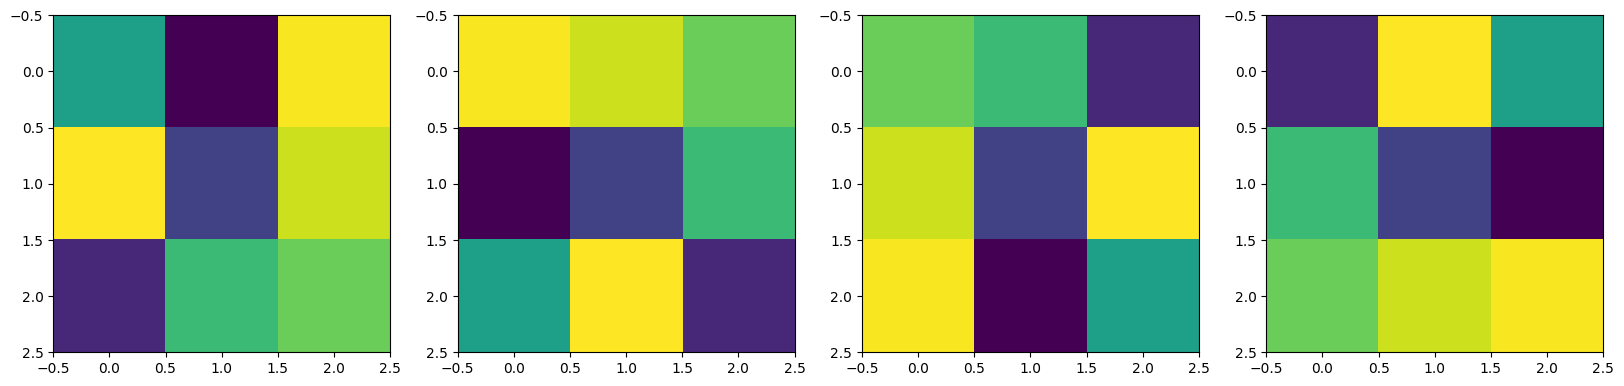

In [5]:
# C4 rotations: e, r, r^2, r^3
x = torch.rand(1,1,3,3)
fig=plt.figure(figsize=(20, 5))
for i in range(1, 5):
    fig.add_subplot(1, 4, i)
    plt.imshow(rot_img(x, np.pi/2*i)[0,0])
plt.show()

## 1.3 Implementing the Lift Convolution

$$f_{out}(\mathbf{x}, r) = (f_{in} * \psi) (\mathbf{x})
= \sum_{\mathbf{y} \in \mathbb{Z}^2}  f_{in}(\mathbf{y})\psi_{r}(\mathbf{y} -\mathbf{x})$$

**In lift convolution, the input convolves with a stack of rotated filters.**

*The reason why we call it lifting is that we add a new axis $r$ in the output feature maps.*

![picture](https://drive.google.com/uc?export=view&id=17RprAkuSe43q_gjsi1al2RX18mZ0o00q)

In [6]:
class LiftingConvolution(nn.Module):
    """Lifting Convolution Layer for finite rotation group

    Attributes:
        in_channels: number of input channels
        out_channels: number of output channels
        kernel_size: kernel size
        group_order: the order of rotation groups
        activation: whether to use relu.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 group_order,
                 activation = True
                 ):
        super(LiftingConvolution, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.group_order = group_order
        self.activation = activation

        # Initialize an unconstrained kernel.
        self.kernel = torch.nn.Parameter(torch.zeros(self.out_channels,
                                                     self.in_channels,
                                                     self.kernel_size,
                                                     self.kernel_size))

        # Initialize weights
        torch.nn.init.kaiming_uniform_(self.kernel.data, a=math.sqrt(5))

    def generate_filter_bank(self):
        # Obtain a stack of rotated filters
        # Rotate kernels by 0, 90, 180, and 270 degrees
        # ==============================
        filter_bank = torch.stack([rot_img(self.kernel, -np.pi*2/self.group_order*i)
                                   for i in range(self.group_order)])
        # ==============================

        # [#out, group_order, #in, k, k]
        filter_bank = filter_bank.transpose(0,1)
        return filter_bank


    def forward(self, x):
        # input shape: [bz, #in, h, w]
        # output shape: [bz, #out, group order, h, w]

        # generate filter bank given input group order
        filter_bank = self.generate_filter_bank()

        # concatenate the first two dims before convolution.
        # ==============================
        x = F.conv2d(
            input=x,
            weight=filter_bank.reshape(
                self.out_channels * self.group_order,
                self.in_channels,
                self.kernel_size,
                self.kernel_size
            ),
            padding = (self.kernel_size-1)//2
        )
        # ==============================

        # reshape output signal to shape [bz, #out, group order, h, w].
        # ==============================
        x = x.view(
            x.shape[0],
            self.out_channels,
            self.group_order,
            x.shape[-1],
            x.shape[-2]
        )
        # ==============================
        if self.activation:
            return F.leaky_relu(x)
        return x

## 1.4 Implementing Group Convolution Kernel

**After the first layer, both the filter and input are now functions on $G=\mathbb{Z}^2 \rtimes C_4$**

*Be careful about this, rotation not only acts on the spatial dimension but also the new $r$ axis. A rotation means a planar rotation and periodic shft.*

*A single channel from regular CNNs is expanded to four channels since we apply kernel with rotations four times.*

$$f_{out}(\mathbf{x}, r) = (f_{in} * \psi) (\mathbf{x}, r)
    = \sum_{\mathbf{y} \in \mathbb{Z}^2} \sum_{r' \in C^4}  f_{in}(\mathbf{y}, r') \psi(r^{-1}(\mathbf{y-x}),r^{-1}r')
$$


![picture](https://drive.google.com/uc?export=view&id=1ADYVLN8veOHRgK_l50p7Vw3-Nvn2E0P9)

In [7]:
class GroupConvolution(nn.Module):
    """Group Convolution Layer for finite rotation group

    Attributes:
        in_channels: number of input channels
        out_channels: number of output channels
        kernel_size: kernel size
        group_order: the order of rotation groups
        activation: whether to use relu.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 group_order,
                 activation = True,
                 ):
        super(GroupConvolution, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.group_order = group_order
        self.activation = activation

        # Initialize an unconstrained kernel.
        # the weights have an additional group order dimension.
        self.kernel = torch.nn.Parameter(torch.zeros(self.out_channels,
                                                     self.in_channels,
                                                     self.group_order, # this is different from the lifting convolution
                                                     self.kernel_size,
                                                     self.kernel_size))

        torch.nn.init.kaiming_uniform_(self.kernel.data, a=math.sqrt(5))


    def generate_filter_bank(self):
        # Obtain a stack of rotated and cyclic shifted filters
        filter_bank = []
        filter = self.kernel.reshape(self.out_channels*self.in_channels,
                                     self.group_order,
                                     self.kernel_size,
                                     self.kernel_size)

        for i in range(self.group_order):
            # planar rotation
            rotated_filter = rot_img(filter, -np.pi*2/self.group_order*i)

            # cyclic shift
            shifted_indices = torch.roll(torch.arange(0, self.group_order, 1), shifts = i)
            shifted_rotated_filter = rotated_filter[:,shifted_indices]


            filter_bank.append(shifted_rotated_filter.reshape(self.out_channels,
                                                              self.in_channels,
                                                              self.group_order,
                                                              self.kernel_size,
                                                              self.kernel_size))
        # reshape output signal to shape [#out, g_order, #in, g_order, k, k].
        filter_bank = torch.stack(filter_bank).transpose(0,1)
        return filter_bank

    def forward(self, x):
        # input shape: [bz, in, group order, x, y]
        # output shape: [bz, out, group order, x, y]

        # Generate filter bank with shape [#out, g_order, #in, g_order, h, w]
        filter_bank = self.generate_filter_bank()

        # Reshape filter_bank to use F.conv2d
        # [#out, g_order, #in, g_order, h, w] -> [#out*g_order, #in*g_order, h, w]
        # ==============================
        x = torch.nn.functional.conv2d(
            input=x.reshape(
                x.shape[0],
                x.shape[1] * x.shape[2],
                x.shape[3],
                x.shape[4]
                ),
            weight=filter_bank.reshape(
                self.out_channels * self.group_order,
                self.in_channels * self.group_order,
                self.kernel_size,
                self.kernel_size
            ),
            padding = (self.kernel_size-1)//2
        )

        # Reshape signal back [bz, #out * g_order, h, w] -> [bz, out, g_order, h, w]
        x = x.view(x.shape[0], self.out_channels, self.group_order, x.shape[-2], x.shape[-1])
        # ========================

        if self.activation:
            return F.leaky_relu(x)
        return x

## 1.5 Test Equivariance

$$ \|f\|_{EE} = sup_{x,g}\|f(\rho_X(g)x) - \rho_Y(g)f(x)\| = 0$$

**Let's build a group equivariant CNNs.**

In [8]:
class GroupEquivariantCNN(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 hidden_dim,
                 group_order,
                 num_gconvs, # number of group convolution layers.
                 classifer = False,
                 sigmoid = False
                 ):
        super().__init__()

        self.gconvs = []
        # First Layer
        self.gconvs.append(LiftingConvolution(in_channels = in_channels,
                                               out_channels = hidden_dim,
                                               kernel_size = kernel_size,
                                               group_order = group_order,
                                               activation = True))
        # Middle Layers
        
        for i in range(num_gconvs-2):
            self.gconvs.append(GroupConvolution(in_channels = hidden_dim,
                                                out_channels = hidden_dim,
                                                kernel_size = kernel_size,
                                                group_order = group_order,
                                                activation = True))
    
        # Final Layer # To generate equivariant outputs
        self.gconvs.append(GroupConvolution(in_channels = hidden_dim,
                                            out_channels = out_channels,
                                            kernel_size = kernel_size,
                                            group_order = group_order,
                                            activation = False))
        self.gconvs = nn.Sequential(*self.gconvs)
        self.classifer = classifer
        self.sigmoid = sigmoid
        
    def forward(self, x):
        # x [bz, c_in, h, w]
        out = self.gconvs(x)
        
        # functions on (g,x,y) -> functions on (x,y)
        # [bz, c_out, |G|, H, W] -> [bz, c_out, H, W]
        out = torch.mean(out, dim = 2)
        
        # If we want to have a invariant classifer, we can average over the spatial dimensions.
        if self.classifer:
            out = torch.mean(out, dim = (2,3))
        if self.sigmoid:
            out = out.sigmoid()
        return out

### Test whether the model is equivariant under C4 transformations.

In [9]:
def test_equivariance(model, group_order, plot = False):
    # Download mnist dataset.
    train_ds = torchvision.datasets.MNIST(root="data", train=True, download=False)
    image = torch.from_numpy(train_ds.data[0].numpy()).unsqueeze(0).unsqueeze(0).float()
    image = (image - image.min())/(image.max() - image.min())


    ## |rf(x) - f(rx)|
    # test whether the model is equivariant under C4 transformations.
    for i in range(group_order):
        theta = np.pi*2/group_order*i
        x = image
        f_x = model(x)
        r_f_x = rot_img(f_x, theta).data.numpy()
        r_x = rot_img(x, theta)
        f_r_x = model(r_x).data.numpy()
        equiv_error = np.mean(np.abs(r_f_x - f_r_x))
        print("Equivariance Error with Rotation {:0.0f} Degrees: {:0.5f}".format(theta/np.pi*2/group_order*360, equiv_error))
        
    if plot:
        titles = ["$x$", "$f(x)$", "$gx$", "$f(gx)$", "$g(f(x))$"]
        vis_imgs = [x[0,0], f_x[0,0].data.numpy(), r_x[0,0].data.numpy(), f_r_x[0,0], r_f_x[0,0]]
        fig=plt.figure(figsize=(10, 5))
        idx = 0
        for i in range(6):
            if i == 1:
                continue
            fig.add_subplot(2, 3, i+1)
            plt.imshow(vis_imgs[idx])
            plt.title(titles[idx], fontsize = 20)
            plt.axis('off')
            idx += 1
        plt.show()

Equivariance Error with Rotation 0 Degrees: 0.00000
Equivariance Error with Rotation 90 Degrees: 0.00000
Equivariance Error with Rotation 180 Degrees: 0.00000
Equivariance Error with Rotation 270 Degrees: 0.00000


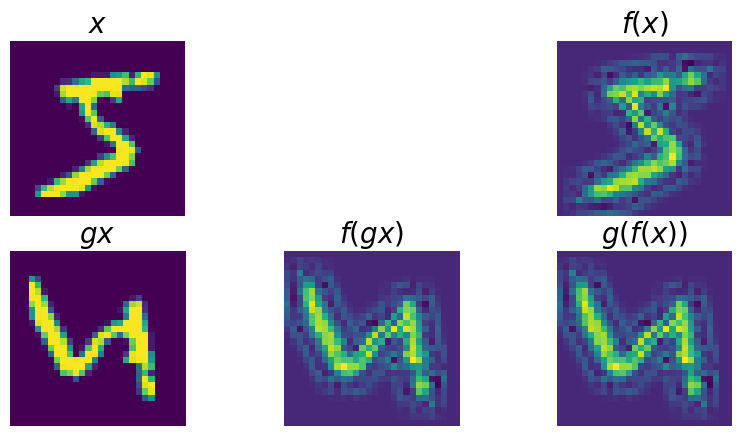

In [10]:
GCNN = GroupEquivariantCNN(in_channels = 1,
                           out_channels = 1,
                           kernel_size = 3,
                           hidden_dim = 4,
                           group_order = 4,
                           num_gconvs = 3)
test_equivariance(GCNN, 4, True)

## 1.6 Experiments on MNIST data

In [11]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [12]:
# We normalize the training data.
train_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                                  ])

# To demonstrate the generalization capabilities our rotation equivariant layers bring, we apply a random
# rotation between 0 and 360 deg to the test set.
test_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.RandomRotation(
                                                     [0, 360],
                                                     torchvision.transforms.InterpolationMode.BILINEAR,
                                                     fill=0),
                                                 torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                                 ])

# We demonstrate our models on the MNIST dataset.
train_ds = torchvision.datasets.MNIST(root="data/MNIST", train=True, transform=train_transform, download=False)
test_ds = torchvision.datasets.MNIST(root="data/MNIST", train=False, transform=test_transform)
train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(train_ds, list(range(50000))), batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(train_ds, list(range(50000, 60000))), batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)

In [13]:
def train_classifer(model, train_loader, valid_loader, test_loader, learning_rate = 0.001, num_epoch = 100):
    print("number of paramters:", sum(p.numel() for p in model.parameters() if p.requires_grad))
    for epoch in range(num_epoch):
        optimizer = torch.optim.Adam(model.parameters(), learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
        loss_fun = nn.CrossEntropyLoss()

        train_acc = []
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            loss = loss_fun(pred, y)  
            acc = (y == pred.argmax(dim=-1)).float().mean().cpu().data.numpy()
            train_acc.append(acc)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        valid_acc = []
        for x, y in valid_loader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            acc = (y == pred.argmax(dim=-1)).float().mean().cpu().data.numpy()
            valid_acc.append(acc)
            
        test_acc = []
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            acc = (y == pred.argmax(dim=-1)).float().mean().cpu().data.numpy()
            test_acc.append(acc)

        print("Epoch {} | Train Accuracy: {:0.5f} | Valid Accuracy: {:0.5f} | Test Accuracy: {:0.5f}".format(epoch+1, np.mean(train_acc), np.mean(valid_acc), np.mean(test_acc)))
            

### Let's train the conventional CNN first.

In [15]:
class CNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, hidden_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size, padding=(kernel_size-1)//2),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size, padding=(kernel_size-1)//2),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, out_channels, kernel_size, padding=(kernel_size-1)//2),
        )

    def forward(self, x):
        out = self.model(x)
        # Apply average pooling over spatial dimensions.
        return out.mean((2,3))
    
CNN = CNN(in_channels = 1, 
          out_channels = 10, 
          kernel_size = 5,
          hidden_dim = 16).to(device)
train_classifer(CNN, train_loader, valid_loader, test_loader, num_epoch = 5)

number of paramters: 10842
Epoch 1 | Train Accuracy: 0.62604 | Valid Accuracy: 0.86425 | Test Accuracy: 0.28165
Epoch 2 | Train Accuracy: 0.88621 | Valid Accuracy: 0.92207 | Test Accuracy: 0.30314
Epoch 3 | Train Accuracy: 0.91932 | Valid Accuracy: 0.93999 | Test Accuracy: 0.31559
Epoch 4 | Train Accuracy: 0.93354 | Valid Accuracy: 0.94984 | Test Accuracy: 0.32604
Epoch 5 | Train Accuracy: 0.94100 | Valid Accuracy: 0.95611 | Test Accuracy: 0.34047


### Next, we train the GCNN!

In [17]:
GCNN = GroupEquivariantCNN(in_channels = 1,
                           out_channels = 10,
                           kernel_size = 5,
                           hidden_dim = 8,
                           group_order = 4,
                           num_gconvs = 3,
                           classifer = True).to(device)
train_classifer(GCNN, train_loader, valid_loader, test_loader, learning_rate = 0.01, num_epoch = 5)

number of paramters: 14600
Epoch 1 | Train Accuracy: 0.26065 | Valid Accuracy: 0.51055 | Test Accuracy: 0.35460
Epoch 2 | Train Accuracy: 0.57225 | Valid Accuracy: 0.63167 | Test Accuracy: 0.47193
Epoch 3 | Train Accuracy: 0.66466 | Valid Accuracy: 0.73806 | Test Accuracy: 0.55195
Epoch 4 | Train Accuracy: 0.70542 | Valid Accuracy: 0.70233 | Test Accuracy: 0.55693
Epoch 5 | Train Accuracy: 0.72456 | Valid Accuracy: 0.76294 | Test Accuracy: 0.51612


### Implementation with the exercise codes

In [19]:
class Image_GConv_Layer(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 group_order,
                 activation = True,
                 lift_conv = False
                 ):
        super(Image_GConv_Layer, self).__init__()
        
        self.lift_conv = lift_conv
        self.kernel_size = kernel_size
        self.activation = activation
        self.group_order = group_order
        self.rep_2D = np.array([[[np.cos(theta), -np.sin(theta)],
                                 [np.sin(theta), np.cos(theta)]] 
                                for theta in [np.pi*2/self.group_order*i
                                              for i in range(group_order)]])

        # Compute the multiplication tables given group elements
        self.mul_table = group_conv.make_multiplication_table(self.rep_2D)
        
        # Compute regular representations of all group elements
        self.rep_reg = torch.from_numpy(group_conv.regular_representation(self.mul_table)).float()
        
        # Find inverse of each element.
        self.inverses_indices = group_conv.inverses(self.mul_table)
        
   
        self.kernel = torch.nn.Parameter(torch.zeros(out_channels,
                                                     in_channels,
                                                     group_order, 
                                                     kernel_size,
                                                     kernel_size))

        torch.nn.init.kaiming_uniform_(self.kernel.data, a=math.sqrt(5))

    def image2D_group_convolution_filter_bank(self, rep_2D, filter):
        """Creates rotated filter bank for 2D image convolution
        Input:
            rep_2D: torch.Tensor of shape [|G|, 2, 2] of the group representation as 2D rotations and mirrors
            filter: torch.Tensor of shape [channel_out, channel_in, rep_reg_filter, kernel_height, kernel_width]
        """
        (j, _, _) = rep_2D.shape
        (d, c, i, kh, kw) = filter.shape
        affine_mat = torch.zeros(j, 2, 3)
        affine_mat[:, :2, :2] = rep_2D
        grid = F.affine_grid(affine_mat, [j, ((d * c) * i), kh, kw], align_corners=False).float().to(filter.device)
        filter_bank = F.grid_sample(filter.reshape(1, ((d * c) * i), kh, kw).repeat(j, 1, 1, 1), grid, align_corners=False)
        return filter_bank.reshape(j, d, c, i, kh, kw)


    def image2D_group_convolution(self, rep_2D, rep_reg, inverses, input, filter):
        """Performs group convolution of inputs and filters over the regular representation
        Input:
            rep_2D: torch.Tensor of shape [|G|, 2, 2] of the group representation as 2D rotations and mirrors
            rep_reg: torch.Tensor of shape [|G|, |G|, |G|] of the left regular representation
            inverse: torch.LongTensor of shape [|G|] with the indices of the inverses of the group elements
            input: torch.Tensor of shape [batch, channel_in, rep_reg_in, height, width]
            filter: torch.Tensor of shape [channel_out, channel_in, rep_reg_filter, kernel_height, kernel_width]
        Output:
            output: torch.Tensor of shape [batch, channel_out, rep_reg_out]
        """
        (k, i, j) = rep_2D.shape
        (z, c, i, h, w) = input.shape
        (d, c, j, kh, kw) = filter.shape
        filter_bank = self.image2D_group_convolution_filter_bank(torch.from_numpy(rep_2D).float(), filter)
        filter_bank_contract = torch.einsum('kij,kdcjhw->dkcihw', rep_reg.to(filter.device), filter_bank[inverses])
        conv = F.conv2d(input.reshape(z, (c * i), h, w), 
                        filter_bank_contract.reshape((d * k), (c * i), kh, kw), 
                        padding=(self.kernel_size-1)//2)
        return conv.reshape(z, d, k, h, w)
    
    def forward(self, x):
        if self.lift_conv:
            x = x.unsqueeze(2).repeat(1, 1, self.group_order, 1, 1)
        out = self.image2D_group_convolution(self.rep_2D, self.rep_reg, self.inverses_indices, x, self.kernel)
        if self.activation:
            return F.leaky_relu(out)
        else:
            return out
        
class Image_GConvNet(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 hidden_dim,
                 group_order,
                 num_gconvs #number of group convolution layers.
                 ):
        super().__init__()

        self.gconvs = []
        # First Layer
        self.gconvs.append(Image_GConv_Layer(in_channels, hidden_dim, kernel_size, group_order, lift_conv = True, activation = True))

        # Middle Layers
        
        for i in range(num_gconvs-2):
            self.gconvs.append(Image_GConv_Layer(hidden_dim, hidden_dim, kernel_size, group_order, lift_conv = False, activation = True))
            
        # Final Layer
        self.gconvs.append(Image_GConv_Layer(hidden_dim, out_channels, kernel_size, group_order, lift_conv = False, activation = False))
        self.gconvs = nn.Sequential(*self.gconvs)
        
    def forward(self, x):

        out = self.gconvs(x)
        
        # functions on (g,x,y) -> functions on (x,y)
        out = torch.mean(out, dim = 2)

        # If we want to have a invariant classifer, we can average over the spatial dimensions.
        out = torch.mean(out, dim = (2,3))
        return out

In [20]:
GConvNet = Image_GConvNet(in_channels = 1,
                          out_channels = 10,
                          kernel_size = 5,
                          hidden_dim = 8,
                          group_order = 4,
                          num_gconvs = 3).to(device)
train_classifer(GConvNet, train_loader, valid_loader, test_loader, learning_rate = 0.01, num_epoch = 5)

number of paramters: 15200
Epoch 1 | Train Accuracy: 0.17022 | Valid Accuracy: 0.19646 | Test Accuracy: 0.20332
Epoch 2 | Train Accuracy: 0.22618 | Valid Accuracy: 0.34942 | Test Accuracy: 0.31628
Epoch 3 | Train Accuracy: 0.35688 | Valid Accuracy: 0.58260 | Test Accuracy: 0.47383
Epoch 4 | Train Accuracy: 0.58764 | Valid Accuracy: 0.75279 | Test Accuracy: 0.53643
Epoch 5 | Train Accuracy: 0.71821 | Valid Accuracy: 0.83818 | Test Accuracy: 0.60689


# 2.  Relaxed Group Convolution Networks

## 2.1 Situations where perfectly equivariant models may not work

### 2.1.1 If the image of 6 is perfectly rotated version of 9, Can GCNN distinguish them?

(-0.5, 15.5, -0.5, 15.5)

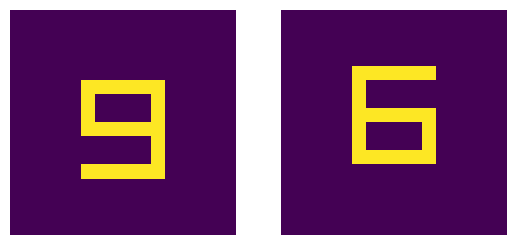

In [22]:
x_6, x_9 = np.zeros((16, 16)), np.zeros((16, 16))
points_6 = [(5, 5),(5, 6),(5, 7),(5, 8),(5, 9),(5, 10),(6, 5),(6, 10),(7, 5),(7, 10),(8, 5),(8, 6),
            (8, 7),(8, 8),(8, 9),(8, 10),(9, 5),(10, 5),(11, 5),(11, 6),(11, 7),(11, 8),(11, 9),(11, 10)]
points_9 = [(4, 5),(4, 6),(4, 7),(4, 8),(4, 9),(4, 10),(5, 10),(6, 10),(7, 5),(7, 6),(7, 7),(7, 8),(7, 9),
            (7, 10),(8, 5),(8, 10),(9, 5),(9, 10),(10, 5),(10, 6),(10, 7), (10, 8),(10, 9),(10, 10)]
for x,y in points_6:
    x_6[x,y] = 1.0
for x,y in points_9:
    x_9[x,y] = 1.0
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(x_9, origin="lower")
axarr[0].axis("off")
axarr[1].imshow(x_6, origin="lower")
axarr[1].axis("off")

In [23]:
def train_model(model, inp, tgt, loss_fun, lr = 1e-3, n_epochs = 200):
    optimizer = torch.optim.Adam(model.parameters(), lr)
    best_loss = 1e6
    for epoch in range(n_epochs):
        output = model(inp)
        loss = loss_fun(output.reshape(tgt.shape), tgt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         # print statistics
        if epoch % max((n_epochs//10), 50) == 0:
            print("Epoch: {} | Loss: {:0.5f} ".format(epoch,  loss.item()))
    if output.device.type == 'cpu':
        return output.data.numpy()
    else:
        return output.cpu().data.numpy()

**You'll see the loss doesn't converge because the C4-GCNN can't distinguish these two digits.**

In [25]:
GCNN = GroupEquivariantCNN(in_channels = 1,
                           out_channels = 1,
                           kernel_size = 3,
                           hidden_dim = 4,
                           group_order = 4,
                           num_gconvs = 1, 
                           classifer = True, 
                           sigmoid = True)
# input images 6 and 9
inps = torch.stack([torch.from_numpy(x_6), torch.from_numpy(x_9)]).unsqueeze(1).float()
# labels
tgts = torch.FloatTensor([0,1])
out = train_model(GCNN, inps, tgts, nn.BCELoss(), n_epochs = 500)

Epoch: 0 | Loss: 0.69318 
Epoch: 50 | Loss: 0.69315 
Epoch: 100 | Loss: 0.69315 
Epoch: 150 | Loss: 0.69315 
Epoch: 200 | Loss: 0.69315 
Epoch: 250 | Loss: 0.69315 
Epoch: 300 | Loss: 0.69315 
Epoch: 350 | Loss: 0.69315 
Epoch: 400 | Loss: 0.69315 
Epoch: 450 | Loss: 0.69315 


### 2.1.2 When the outputs have lower symmetry than input.

*Smidt et al. [Finding Symmetry Breaking Order Parameters with Euclidean Neural Networks](https://arxiv.org/abs/2007.02005)*

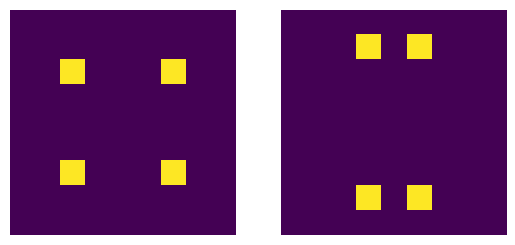

In [26]:
# D4
square_image = torch.zeros((9,9))
square_image[2,2] = 1.0
square_image[2,6] = 1.0
square_image[6,2] = 1.0
square_image[6,6] = 1.0
square_image = square_image[None, None]

# D2
rect_image = torch.zeros((9,9))
rect_image[1,3] = 1.0
rect_image[1,5] = 1.0
rect_image[7,3] = 1.0
rect_image[7,5] = 1.0
rect_image = rect_image[None, None]

# Random
rand_image = torch.zeros((9,9))
rand_image[1,3] = 1.0
rand_image[1,7] = 1.0
rand_image[7,3] = 1.0
rand_image[7,5] = 1.0
rand_image = rand_image[None, None]

f, axarr = plt.subplots(1,2) 
axarr[0].imshow(square_image[0,0], origin="lower")
axarr[0].axis("off")
axarr[1].imshow(rect_image[0,0], origin="lower")
axarr[1].axis("off")
plt.show()

Epoch: 0 | Loss: 0.05063 
Epoch: 50 | Loss: 0.03455 
Epoch: 100 | Loss: 0.02485 
Epoch: 150 | Loss: 0.02469 
Epoch: 200 | Loss: 0.02469 
Epoch: 250 | Loss: 0.02469 
Epoch: 300 | Loss: 0.02469 
Epoch: 350 | Loss: 0.02469 
Epoch: 400 | Loss: 0.02469 
Epoch: 450 | Loss: 0.02469 


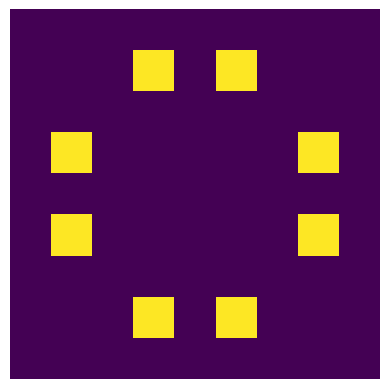

In [29]:
GCNN = GroupEquivariantCNN(in_channels = 1,
                           out_channels = 1,
                           kernel_size = 3,
                           hidden_dim = 16,
                           group_order = 4,
                           num_gconvs = 3)
out = train_model(GCNN, square_image, rect_image, nn.MSELoss(), n_epochs = 500)

# visualize the prediction
plt.imshow(out[0,0])
plt.axis("off")
plt.show()

### 2.1.3 When the physical systems do not have perfect symmetry or have lower symmetry than expected.

* Wang et al. [Discovering Symmetry Breaking in Physical Systems with Relaxed Group Convolution](https://arxiv.org/abs/2310.02299).*

## 2.2 Approximate Equivariance
Let $f \colon X \to Y$ be a function and $G$ be a group. Assume that $G$ acts on $X$ and $Y$ via representations $\rho_{X}$ and $\rho_{Y}$. We say $f$ is $\epsilon$-approximately $G$-equivariant if for any $g \in G$,

$$ \|f(\rho_{X}(g)(x)) - \rho_{Y}(g)f(x)\| \leq \epsilon. $$

Note that strictly equivariant functions are $\epsilon = 0$ **approximately equivariant**.

## 2.3 Relaxed Group Convolution
**We relax the weight-sharing constraints in Equivariant Networks by introducing group element dependent parameters.**

Group Convolution: $$[f * \psi] (g) =  \sum_{h \in G}f(h)\psi(g^{-1} h)$$
The $G$-equivariance of group convolution results from the shared kernel $\psi(g^{-1}h)$.  To relax this and consequently relax the $G$-equivariance, we replace the single kernel $\psi$ with a set of kernels $\lbrace \psi_l \rbrace_{l=1}^L$. We define the new kernel $\psi$ as a linear combination of $\psi_l$ with coefficients that vary with $h$ and thus introduce symmetry-breaking dependence on the specific pair $(g,h)$,

$$ \psi(g,h) = \sum_{l=1}^L w_l(h) \psi_l(g^{-1}h). $$
We define relaxed group convolution by multiplication with $\psi$ as such

$$[f {\Large\star} \psi](g) = \sum_{h\in G}f(h)\psi(g, h)
  = \sum_{h\in G}\sum_{l=1}^L f(h) w_l(h) \psi_l(g^{-1}h) $$

By varying the number of kernels $L$, we can control the degree of relaxation of equivariance. The weights $w_i(h) \in \mathbb{R}$ and the kernels $\psi_l(g^{-1}h) \in \mathbb{R}^{c_\mathrm{out} \times c_\mathrm{in}}$ can be learnt from data.  Relaxed group convolution reduces to group convolution and is fully equivariant if and only if $g_1^{-1}h_1 = g_2^{-1} h_2$ implies $\psi(g_1,h_1) = \psi(g_2,h_2)$.  In particular, this occurs if $w_l(h_1) =  w_l(h_2)$ for all $h_1,h_2 \in G$ and for all $l$.

e.g. To relax translation equivariance, instead of using a single filter, we use a linear combination of multiple filters where the coefficients can be varying across the input location.

![picture](https://drive.google.com/uc?export=view&id=1oNcmOFXuedlOkX-rQ8Pq4_fssEw4TOCm)

## 2.4 Implementing Relaxed Rotaion Equivariant Layers

In [30]:
##### 2D Relaxed Rotation Lifting Convolution Layer #####
class RelaxedRotLiftConv2d(torch.nn.Module):
    """Relaxed lifting convolution Layer for 2D finite rotation group"""
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 group_order, # the order of 2d finite rotation group
                 num_filter_banks,
                 activation = True # whether to apply relu in the end
                 ):
        super(RelaxedRotLiftConv2d, self).__init__()

        self.num_filter_banks = num_filter_banks
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.group_order = group_order
        self.activation = activation
  
        # The relaxed weights are initialized as equal
        # they do not need to be equal across different filter bank
        self.relaxed_weights = torch.nn.Parameter(torch.ones(num_filter_banks, group_order).float())

        # Initialize an unconstrained kernel.
        self.kernel = torch.nn.Parameter(torch.zeros(self.num_filter_banks, # Additional dimension
                                                     self.out_channels,
                                                     self.in_channels,
                                                     self.kernel_size,
                                                     self.kernel_size))
        torch.nn.init.kaiming_uniform_(self.kernel.data, a=math.sqrt(5))
        
    def generate_filter_bank(self):
        """ Obtain a stack of rotated filters"""
        weights = self.kernel.reshape(self.num_filter_banks*self.out_channels,
                                      self.in_channels,
                                      self.kernel_size,
                                      self.kernel_size)
        filter_bank = torch.stack([rot_img(weights, -np.pi*2/self.group_order*i)
                                   for i in range(self.group_order)])
        filter_bank = filter_bank.transpose(0,1).reshape(self.num_filter_banks, # Additional dimension
                                                         self.out_channels,
                                                         self.group_order,
                                                         self.in_channels,
                                                         self.kernel_size,
                                                         self.kernel_size)
        return filter_bank


    def forward(self, x):
        # input shape: [bz, #in, h, w]
        # output shape: [bz, #out, group order, h, w]

        # generate filter bank given input group order
        filter_bank = self.generate_filter_bank()

        # for each rotation, we have a linear combination of multiple filters with different coefficients.
        relaxed_conv_weights = torch.einsum("na, noa... -> oa...", self.relaxed_weights, filter_bank)

        # concatenate the first two dims before convolution.
        # ==============================
        x = F.conv2d(
            input=x,
            weight=relaxed_conv_weights.reshape(
                self.out_channels * self.group_order,
                self.in_channels,
                self.kernel_size,
                self.kernel_size
            ),
            padding = (self.kernel_size-1)//2
        )
        # ==============================

        # reshape output signal to shape [bz, #out, group order, h, w].
        # ==============================
        x = x.view(
            x.shape[0],
            self.out_channels,
            self.group_order,
            x.shape[-1],
            x.shape[-2]
        )
        # ==============================

        if self.activation:
            return F.leaky_relu(x)
        return x

In [31]:
##### 2D Relaxed Rotation Group Convolution Layer #####
class RelaxedRotGroupConv2d(torch.nn.Module):
    """Relaxed group convolution Layer for 2D finite rotation group"""
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 group_order, # the order of 2d finite rotation group
                 num_filter_banks,
                 activation = True # whether to apply relu in the end
                ):

        super(RelaxedRotGroupConv2d, self).__init__()

        self.num_filter_banks = num_filter_banks
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.group_order = group_order
        self.activation = activation


        # Initialize weights
        # If relaxed_weights are equal values, then the model is still equivariant
        # Relaxed weights do not need to be equal across different filter bank
        self.relaxed_weights = torch.nn.Parameter(torch.ones(group_order, num_filter_banks).float())
        self.kernel = torch.nn.Parameter(torch.randn(self.num_filter_banks, # additional dimension
                                                     self.out_channels,
                                                     self.in_channels,
                                                     self.group_order,
                                                     self.kernel_size,
                                                     self.kernel_size))

        torch.nn.init.kaiming_uniform_(self.kernel.data, a=math.sqrt(5))

        
    def generate_filter_bank(self):
        """ Obtain a stack of rotated and cyclic shifted filters"""
        filter_bank = []
        weights = self.kernel.reshape(self.num_filter_banks*self.out_channels*self.in_channels,
                                      self.group_order,
                                      self.kernel_size,
                                      self.kernel_size)

        for i in range(self.group_order):
            # planar rotation
            rotated_filter = rot_img(weights, -np.pi*2/self.group_order*i)

            # cyclic shift
            shifted_indices = torch.roll(torch.arange(0, self.group_order, 1), shifts = i)
            shifted_rotated_filter = rotated_filter[:,shifted_indices]


            filter_bank.append(shifted_rotated_filter.reshape(self.num_filter_banks,
                                                              self.out_channels,
                                                              self.in_channels,
                                                              self.group_order,
                                                              self.kernel_size,
                                                              self.kernel_size))
        # stack
        filter_bank = torch.stack(filter_bank).permute(1,2,0,3,4,5,6)
        return filter_bank
    
    def forward(self, x):

        filter_bank = self.generate_filter_bank()

        relaxed_conv_weights = torch.einsum("na, aon... -> on...", self.relaxed_weights, filter_bank)

        x = torch.nn.functional.conv2d(
            input=x.reshape(
                x.shape[0],
                x.shape[1] * x.shape[2],
                x.shape[3],
                x.shape[4]
                ),
            weight=relaxed_conv_weights.reshape(
                self.out_channels * self.group_order,
                self.in_channels * self.group_order,
                self.kernel_size,
                self.kernel_size
            ),
            padding = (self.kernel_size-1)//2
        )

        # Reshape signal back [bz, #out * g_order, h, w] -> [bz, out, g_order, h, w]
        x = x.view(x.shape[0], self.out_channels, self.group_order, x.shape[-2], x.shape[-1])
        # ========================
        if self.activation:
            return F.leaky_relu(x)
        return x


In [32]:
class RelaxedRotCNN2d(torch.nn.Module):
    """A small relaxed rotation 2d CNN model"""
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size, 
                 hidden_dim, 
                 group_order, # the order of 2d finite rotation group
                 num_gconvs, # number of group conv layers
                 num_filter_banks, 
                 classifier = False,
                 sigmoid = False,
                ):
        super(RelaxedRotCNN2d, self).__init__()
        
        self.gconvs = []
        self.classifier = classifier
        self.sigmoid = sigmoid
        
        self.gconvs = [RelaxedRotLiftConv2d(in_channels, hidden_dim, kernel_size, group_order, num_filter_banks, True)]

        for i in range(num_gconvs-2):
            self.gconvs.append(RelaxedRotGroupConv2d(hidden_dim, hidden_dim, kernel_size, group_order, num_filter_banks, True))

        self.gconvs.append(RelaxedRotGroupConv2d(hidden_dim, out_channels, kernel_size, group_order, num_filter_banks, False))

        self.gconvs = torch.nn.Sequential(*self.gconvs)

    def forward(self, x): 
        # average over h axis or not         
        out = self.gconvs(x).mean(2)
        
        if self.classifier:
            out = out.mean((2,3))
        if self.sigmoid:
            out = out.sigmoid()
        return out


In [33]:
Relaxed_GConvNet = RelaxedRotCNN2d(in_channels = 1, 
                                   out_channels = 1, 
                                   kernel_size = 3, 
                                   hidden_dim = 8, 
                                   group_order = 4,
                                   num_gconvs = 3, 
                                   num_filter_banks=1)
test_equivariance(Relaxed_GConvNet, 4)

Equivariance Error with Rotation 0 Degrees: 0.00000
Equivariance Error with Rotation 90 Degrees: 0.00000
Equivariance Error with Rotation 180 Degrees: 0.00000
Equivariance Error with Rotation 270 Degrees: 0.00000


#### Let's train a Relaxed GCNN classifier to distinguish image 9 and 6. Does the loss converge?

In [34]:
Relaxed_GConvNet = RelaxedRotCNN2d(in_channels = 1, 
                                   out_channels = 1, 
                                   kernel_size = 3, 
                                   hidden_dim = 8, 
                                   group_order = 4,
                                   num_gconvs = 3, 
                                   num_filter_banks=1,
                                   classifier = True,
                                   sigmoid = True)
out = train_model(Relaxed_GConvNet, inps, tgts, nn.BCELoss(), n_epochs = 500)

Epoch: 0 | Loss: 0.69315 
Epoch: 50 | Loss: 0.69229 
Epoch: 100 | Loss: 0.64459 
Epoch: 150 | Loss: 0.36013 
Epoch: 200 | Loss: 0.08413 
Epoch: 250 | Loss: 0.02209 
Epoch: 300 | Loss: 0.00982 
Epoch: 350 | Loss: 0.00564 
Epoch: 400 | Loss: 0.00368 
Epoch: 450 | Loss: 0.00260 


## 2.5 Discovering Symmetry Breaking Factors

In [35]:
# Square to Square
Relaxed_GConvNet_SS = RelaxedRotCNN2d(in_channels = 1, out_channels = 1, kernel_size = 3, hidden_dim = 4, group_order = 4, num_gconvs = 3, num_filter_banks=1).to(device)
out_square = train_model(model = Relaxed_GConvNet_SS, inp = square_image.to(device), tgt = square_image.to(device), loss_fun = nn.MSELoss())

# Square to Rectangle
Relaxed_GConvNet_SR = RelaxedRotCNN2d(in_channels = 1, out_channels = 1, kernel_size = 3, hidden_dim = 8, group_order = 4, num_gconvs = 3, num_filter_banks=1).to(device)
out_rectangle = train_model(model = Relaxed_GConvNet_SR, inp = square_image.to(device), tgt = rect_image.to(device), loss_fun = nn.MSELoss())

# # Square to Non-symmetric shape
Relaxed_GConvNet_SN = RelaxedRotCNN2d(in_channels = 1, out_channels = 1, kernel_size = 3, hidden_dim = 8, group_order = 4, num_gconvs = 3, num_filter_banks=1).to(device)
out_random = train_model(model = Relaxed_GConvNet_SN, inp = square_image.to(device), tgt = rand_image.to(device), loss_fun = nn.MSELoss())

Epoch: 0 | Loss: 0.04936 
Epoch: 50 | Loss: 0.00428 
Epoch: 100 | Loss: 0.00005 
Epoch: 150 | Loss: 0.00001 
Epoch: 0 | Loss: 0.04938 
Epoch: 50 | Loss: 0.03696 
Epoch: 100 | Loss: 0.03429 
Epoch: 150 | Loss: 0.01700 
Epoch: 0 | Loss: 0.04931 
Epoch: 50 | Loss: 0.03713 
Epoch: 100 | Loss: 0.03381 
Epoch: 150 | Loss: 0.02903 


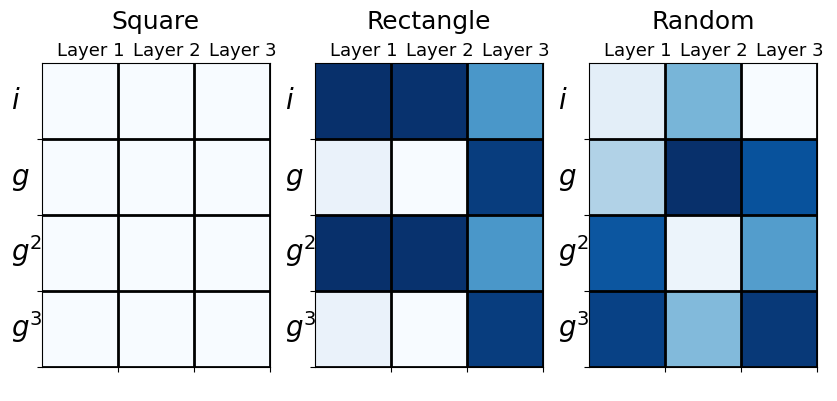

In [36]:
relaxed_weights_ss = torch.stack([Relaxed_GConvNet_SS.gconvs[i].relaxed_weights.data.reshape(-1) for i in range(3)]).T.cpu().data.numpy()
relaxed_weights_sr = torch.stack([Relaxed_GConvNet_SR.gconvs[i].relaxed_weights.data.reshape(-1) for i in range(3)]).T.cpu().data.numpy()
relaxed_weights_sn = torch.stack([Relaxed_GConvNet_SN.gconvs[i].relaxed_weights.data.reshape(-1) for i in range(3)]).T.cpu().data.numpy()
relaxed_weights = [relaxed_weights_ss, relaxed_weights_sr, relaxed_weights_sn]
titles = ["Square", "Rectangle", "Random"]
fig=plt.figure(figsize=(10, 5))
for i in range(1, 4):
    fig.add_subplot(1, 3, i)
    plt.imshow(relaxed_weights[i-1], cmap = 'Blues')
    plt.xticks(np.arange(0.5,3,1), color='w')
    plt.yticks(np.arange(0.5,4,1), color='w')
    plt.text(-0.9, 0.1, "$i$", fontsize=20)
    plt.text(-0.9, 1.1, "$g$", fontsize=20)
    plt.text(-0.9, 2.1, "$g^2$", fontsize=20)
    plt.text(-0.9, 3.1, "$g^3$", fontsize=20)
    plt.text(-0.3, -0.6, "Layer 1", fontsize=13)
    plt.text(0.7, -0.6, "Layer 2", fontsize=13)
    plt.text(1.7, -0.6, "Layer 3", fontsize=13)
    plt.grid(color='black', linestyle='-', linewidth=2)
    plt.title(titles[i-1], size = 18, pad=25)
plt.show()

## 2.6 Projecting the relaxed weights onto the irreps of the group

In [37]:
# Character Table
c4_ft = np.array([[1, 1, 1, 1],
                  [1, -1, 1, -1],
                  [1, 0+1j, -1, 0-1j],
                  [1, 0-1j, -1, 0+1j]])

fourier_components_ss = np.round(relaxed_weights_ss[:,0] @ c4_ft.T, decimals = 3)
fourier_components_sr = np.round(relaxed_weights_sr[:,0] @ c4_ft.T, decimals = 3)
fourier_components_sn = np.round(relaxed_weights_sn[:,0] @ c4_ft.T, decimals = 3)

#### Only trivial irrep A is non zero when the output is an square

In [38]:
fourier_components_ss

array([4.238+0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j])

#### Both A and B are non zero when the output is a rectangle

In [39]:
fourier_components_sr

array([4.192+0.j, 0.785+0.j, 0.   +0.j, 0.   +0.j])